Overview
=======
This notebook documents how to run the python module (FitSource.py) to fit source spectra in terms of seismic moment and corner frequency, and to derive other seismological parameters (e.g. stress drop, radiated energy).





**NOTE**: This notebook is only tested for a GNU/Linux distribution.

#### Setup

In [1]:
import argparse
import sys
import os
import glob
import json
import math
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
#plt.matplotlib.use()
from LibGit.utilities import valid_true_false,argumentFitSource,check_Mw,check_f_range,check_1D_model,convert_strings_to_floats,fun_spectral_fit,linfun,fmintofit,plot_ksource_distrib,plot_fc_vs_M0,plot_M_vs_Mw
from LibGit.format_utils import dict_fmt
from LibGit.ConfSourceFit import ConfSourceFit 
from LibGit.Source import Source
from LibGit import EvtGit
from scipy.optimize import curve_fit

In [2]:
class ArgumentParserError(Exception): pass
class CustomArgumentParser(argparse.ArgumentParser):
    def error(self, message):
        raise ArgumentParserError(message)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

#### Add the arguments of the command line in the next cell

| Options    | Description | Default
| -------- | ------- | ------- 
| config | configuration file in YAML format to set the source fitting.  | None
| output | output file format are: 'csv' and  'json'; to save data in both formats set 'all'     | all
| log | log file in TXT format | logsource.txt
| v    | Verbose mode (prints summary and other details)    | True

In [3]:
opts_str = "--config Conf_FitSource.yaml"

#### Creating an ArgumentParser object to hold all the command line arguments

In [4]:
synopsis = 'Return source parameters for each event fitting source terms obtained by GIT'
usage = "example: %prog --input_file /path/to/source_directory/ --config_file=configfile"
p = argparse.ArgumentParser(description=synopsis + '\n' + usage)

#### Adding arguments

In [5]:
p.add_argument("--config", "--configuration_file", action="store", dest="configFile",  default=None, help="configuration file in YAML format to set the source fitting. Default: None")
p.add_argument("--output", "--output_format", action="store", dest="output",  default="all", choices=["csv", "json", "all"], help="output file format; default all")
p.add_argument("--log", "--log_file", action="store", dest="LogFile",  default="logsource.txt", help="log file in TXT format.")
p.add_argument("--v", "--verbose", action="store", dest="verb", type=valid_true_false, default='True', help="Verbose mode (prints summary and other details). Default: True")  

_StoreAction(option_strings=['--v', '--verbose'], dest='verb', nargs=None, const=None, default='True', type=<function valid_true_false at 0x7f106fa55550>, choices=None, help='Verbose mode (prints summary and other details). Default: True', metavar=None)

#### Parsing arguments

In [6]:
opts_str_lst = opts_str.replace("'", "").replace('=',' ').split(' ')
opts = p.parse_args(opts_str_lst)
print(opts)

Namespace(LogFile='logsource.txt', configFile='Conf_FitSource.yaml', output='all', verb=True)


In [7]:
# to read the file with the configuration parameters for the source spectra
ConfigFile = ConfSourceFit(opts.configFile,opts.verb)

-- Section GLOBAL --
> Source Dir: /home/mariaclara/gitpy/GITOUT/SOURCES 
Warning!! the folder /home/mariaclara/gitpy/GITOUT/FITSOURCE/fitmod1 already exists, do you want to refresh it?
Directory removed successfully
> Out Dir: /home/mariaclara/gitpy/GITOUT/FITSOURCE 
> Job Name: gitpy-trial 
> Output Dir: /home/mariaclara/gitpy/GITOUT/FITSOURCE 
> Reference Distance [km]: 10.0 
> Radiation Pattern: 0.55 
> Free surface coefficient: 2.0 
> Splitting component: 2.0 
-- Section CRUSTALMODEL --
> crustal_model: HETEROGENEOUS 
> Crustal model file: /home/mariaclara/gitpy/input_examples/1D_crustal_model.txt 
> S wave velocity [km/s]: 3.2 
> Crustal medium density [g/cm^3]: 2.7 
-- Section SOURCEFITTING --
> type of fitting: simultaneous fit for M0 and fc 
> type of source of model: Brune's model 
Source Fitting between an automatically calculated fmin and fmax = 30 Hz
....calculating fmin and fmax
...working on source spectra (*.source) 
-- Section KAPPA --
> Hinge Frequency for Kappa [Hz]:

#### To anchorate the Mw to a reference magnitude catalogue

In [8]:
if ConfigFile.anchorage_mw == 1 and ConfigFile.sourcetype == 1:
    error_message = 'ERROR!!! apparent source spectra cannot be anchorated to a reference magnitude catalogue, this functionality will be implemented in future releases of GITpy'
    print('----------------------------------')
    print(error_message)
    print('----------------------------------')
    sys.exit()
    
#check file with fixed Mw    
EvEID, MagFILE, FIXFLAG = check_Mw(ConfigFile,opts,None)
if ConfigFile.f_range == 1: 
    MMIN,MMAX,FMIN,FMAX = check_f_range(ConfigFile,opts,None)

#### Reading the Source Files...

In [9]:
source_dir = ConfigFile.source_dir
if ConfigFile.sourcetype == 1:
    source_file = []
    for elem in ConfigFile.fit_apps_list:
        if ConfigFile.sourcetype == 1:
            source_file.append(ConfigFile.source_dir + '/' + str(elem) + '.app_source')
        else:
            source_file.append(ConfigFile.source_dir + '/' + str(elem) + '.source')        
else:
    source_file = glob.glob(source_dir+"/*.source")

#### Fitting the non-parametric Source Spectra to obtain M<sub>0</sub> and f<sub>c</sub>
To simultaneously fit M<sub>0</sub> and f<sub>c</sub>, as first step the acceleration source spectra is corrected at frequency >= f<sub>h</sub> to remove the kappa effects. After that, the fitting by Brune model is done considering displacement source spectra, theoretical value of M<sub>0</sub> and f<sub>c</sub>, M<sub>0</sub> > 0 , f<sub>c</sub> > 0.

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/161031083717.source 

#### Fitting Parameters####

log10(M0) =  20.6 Nm
fc =  0.0 Hz
Correlation (M0,fc)  -1.0000
ks =  -0.005 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/160824053124.source 

#### Fitting Parameters####

log10(M0) =  15.7 Nm
fc =  0.9 Hz
Correlation (M0,fc)  -0.9989
ks =  -0.005 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/161123013414.source 

#### Fitting Parameters####

log10(M0) =  15.5 Nm
fc =  0.9 Hz
Correlation (M0,fc)  -0.9975
ks =  0.012 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/170709223924.source 

#### Fitting Parameters####

log10(M0) =  15.1 Nm
fc =  1.4 Hz
Correlation (M0,fc)  -0.9871
ks =  -0.000 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/1804

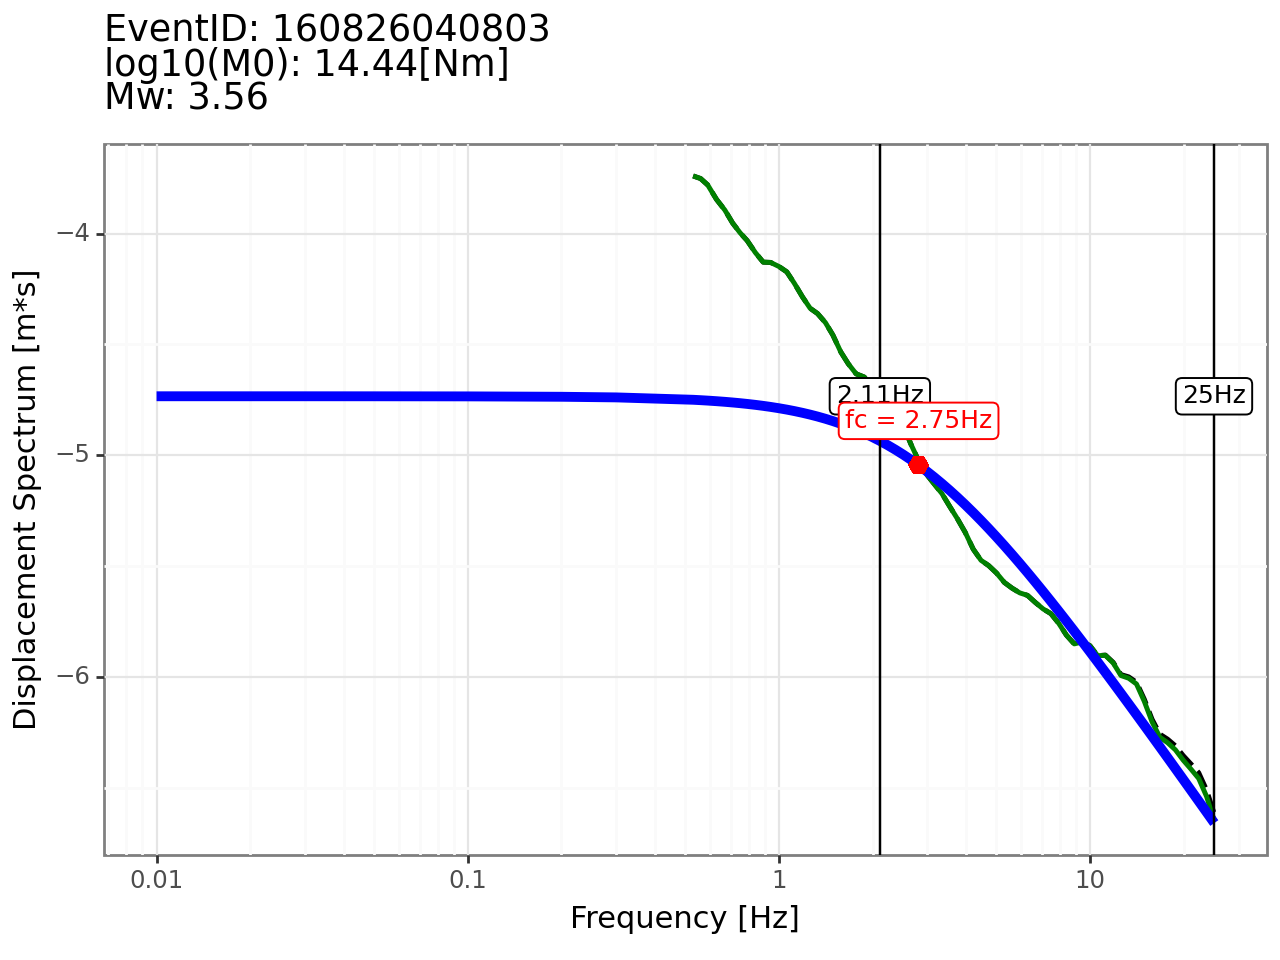


....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/170118105347.source 

#### Fitting Parameters####

log10(M0) =  20.3 Nm
fc =  0.0 Hz
Correlation (M0,fc)  -1.0000
ks =  0.007 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/161031085809.source 

#### Fitting Parameters####

log10(M0) =  16.0 Nm
fc =  0.4 Hz
Correlation (M0,fc)  -0.9999
ks =  0.004 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/161101063656.source 

#### Fitting Parameters####

log10(M0) =  15.3 Nm
fc =  2.0 Hz
Correlation (M0,fc)  -0.9928
ks =  0.020 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/161031032740.source 

#### Fitting Parameters####

log10(M0) =  21.5 Nm
fc =  0.0 Hz
Correlation (M0,fc)  -1.0000
ks =  0.010 s
###########################

....... START reading Source File: /home/mariaclara/gitpy/GITOUT/SOURCES/160827

In [10]:
g  = 0
SIGMEANOFF = np.nan
MEANOFF = np.nan
while g == 0:
    kappa = list()
    kappa_error = list()
    M0_val = list()
    M0_error=list()
    M0_fc_corr_=list()
    fc=list()
    fc_error=list()
    ideve = list()
    fmin_ = list()
    fmax_ = list()
    stressd = list()
    stressd_error = list()
    Mag = list()
    Mfas_ = list()
    Mcat_ = list()
    Mwflag_ = list()
    log_10_Er_mod_ = list()
    App_stress_ = list()
    log_10_Er_oss_ = list()
    log_10_Er_oss_fit_ = list()
    App_stress_oss_ = list()
    log_10_Er_tot_ = list()
    log_10_Er_tot_fit_ = list()
    ηSW_ = list()
    κv_ = list()
    κv_fmin_fmax_fit_ = list()
    errors = {'ideve': list(), 'message': list()}
    warning = {'ideve': list(), 'M': list(), 'f_c': list(), '#k_sample': list()}
    MagFILE = [float(x) for x in MagFILE] 
    event_list_data = []
    for filename in source_file: 
        nameFile = filename
        msg = argumentFitSource(nameFile)
        s1 = "....... START reading Source File: {:s} ".format(msg["file_name"])    
        if opts.verb == True: print(s1)
        Evt = EvtGit(msg["file_name"])
        Mfas = Evt.Ml
        mag_flag = 0
        event_list_data.append(Evt.Id0)
        if EvEID is not None:
            try:
                index = EvEID.index(Evt.Id0)
            except ValueError:
                index = None
            if index is not None and float(FIXFLAG[index]) == 1:
                Evt.Ml = MagFILE[index]
                Mcat = MagFILE[index]
                MWflag = float(FIXFLAG[index])
                mag_flag = 1
            elif index is not None and float(FIXFLAG[index]) == 0:
                Mcat = MagFILE[index]
                MWflag = float(FIXFLAG[index])
            elif index is None:
                Mcat = -9
                MWflag = -9
        Sour = Source(msg["file_name"])
                    
        if MEANOFF is not np.nan and ConfigFile.anchorage_mw ==1:
            evt = open(msg["file_name"], "r")
            line = evt.readline()
            values = evt.read()
            line = line.rstrip('\n')
            line = line.split()[0] + ' ' + line.split()[1] + ' ' + line.split()[2] + '  ' + line.split()[3] + '   ' + line.split()[4] + '   ' + line.split()[5] + '    ' + line.split()[6] + '    ' + line.split()[7]
            evt.close()              
            if SIGMEANOFF >=0:
                tmpamp = np.array([float(x) for x in Sour.Amp]) - 1.5*MEANOFF
                line = line + '    ' + str('{:.3f}'.format(-1.5*MEANOFF))
            else:
                tmpamp = np.array([float(x) for x in Sour.Amp]) + 1.5*MEANOFF
                line = line + '    ' + str('{:.3f}'.format(1.5*MEANOFF))
            evt = open(msg["file_name"], "w")
            evt.write(line + "\n")
            evt.write(values)
            evt.close()
            Sour.Amp = tmpamp.tolist()
            s1 = "WARNING! The Acceleration Source Spectra are anchorated to the reference Mw values in : {:s} ".format(ConfigFile.magnitude_file)
            if opts.verb: print(s1)
        
        if ConfigFile.sourcetype != 1:
            dict_Amp_spectra = {'Frequency [Hz]':np.array(Sour.freq, dtype=float), 'Acceleration Spectrum [m/s]': np.array(Sour.Amp, dtype=float)}
            d1 = pd.DataFrame(dict_Amp_spectra)
            #Sour.plotSources('prova.jpg',True,False,'ACC')
            d1 = d1.loc[~d1['Acceleration Spectrum [m/s]'].isnull()]        
        # to calcule the starting value of M0 and fc useful for the source spectra fitting with the Brune model
        M0_dyne_cm,M0_N_m = Sour.calculate_M0()
        if ConfigFile.type_model == 'HOMOGENEOUS':
            VS = ConfigFile.Vs
            RHO = ConfigFile.rho
        elif ConfigFile.type_model == 'HETEROGENEOUS':
            DEPTH,VP,VS,RHO = check_1D_model(ConfigFile,opts,None)
            val1 = Evt.Dpt >= np.array(convert_strings_to_floats(DEPTH))
            try:
                index = np.where(val1)[0][-1] +1 
            except:
                index = 1
            VS = float(VS[index])
            RHO = float(RHO[index])
        f_c = Sour.calculate_fc(VS,30,M0_dyne_cm)
        # to calculate the constant value of the Brune model
        const = np.log10(ConfigFile.Rp*ConfigFile.En*ConfigFile.Fs/(4*math.pi*RHO*1000*ConfigFile.dref*1000*np.power(VS*1000,3)))
        if ConfigFile.sourcetype != 1:
            d1.loc[:,'Displacement Spectrum [m*s]'] = d1['Acceleration Spectrum [m/s]'].tolist() - 2*np.log10(2*math.pi*d1['Frequency [Hz]']) - 2 # Spettro in spostamento in metri*sec
            d1.loc[:,'Velocity Spectrum [m]'] = d1['Acceleration Spectrum [m/s]'].tolist() - np.log10(2*math.pi*d1['Frequency [Hz]']) - 2 # Spettro in velocità 
        if ConfigFile.sourcetype == 1:
            
            df_acc = Evt.app_source
            
            df_disp_tmp = df_acc.iloc[0:-1, 4:-1].astype(float) - 2*np.log10(2*math.pi*df_acc.iloc[0:-1, 4:-1].head(0).columns.astype(float))
            df_disp = pd.concat([df_acc.iloc[0:-1, 0:4],df_disp_tmp], axis=1)
            
            df_vel_tmp =  df_acc.iloc[0:-1, 4:-1].astype(float) - np.log10(2*math.pi*Evt.app_source.iloc[0:-1, 4:-1].head(0).columns.astype(float)) - 2
            df_vel = pd.concat([df_acc.iloc[0:-1, 0:4],df_vel_tmp], axis=1)
        if ConfigFile.f_range ==1:
            val1 = np.array(convert_strings_to_floats(MMIN)) > Evt.Ml
            val2 = np.array(convert_strings_to_floats(MMAX)) < Evt.Ml
            val3 = val1 == val2
            index = np.where(val3)[0][0]
            fmin = float(FMIN[index])
            fmax = float(FMAX[index])
        else:
            fmin = fmintofit (d1,3)
            fmax = 25
        if opts.verb == True: print('')
        s1 = "#### Fitting Parameters####"    
        if opts.verb == True: print(s1)
        if ConfigFile.type == 1:
            # method1: to simultaneously fit M0 and fc. As first step the acceleration source spectra is corrected at frequency >= fh to remove the kappa effects; as second step the fitting by Brune model is done considering displacement source spectra, theoretical value of M0 and fc, M0 > 0, fc > 0.
            
            if ConfigFile.sourcetype != 1:
                dataf = d1
                indsta = None
                result_dict = Sour.method1(dataf,ConfigFile,Evt,const,M0_N_m,f_c,opts,errors,warning,fmin,fmax,VS,mag_flag,Mcat,MWflag,indsta)
                
            elif ConfigFile.sourcetype == 1:
                dataf = df_acc
                pd_sta_tmp = pd.DataFrame()
                for indsta in list(dataf.index.values.tolist()):
                    result_dict = Sour.method1(dataf,ConfigFile,Evt,const,M0_N_m,f_c,opts,errors,warning,fmin,fmax,VS,mag_flag,Mcat,MWflag,indsta)
                    pd_sta = pd.DataFrame.from_dict(result_dict,orient='index')
                    pd_sta_tmp = pd.concat([pd_sta,pd_sta_tmp], axis=1)
                
                pd_sta_tmp = pd_sta_tmp.drop('error_message')
                pd_sta_tmp = pd_sta_tmp.drop('warnings')
                pd_sta_tmp.to_csv(ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + str(Evt.Id0) + '_appsource_param.csv',header=False)
                
                
                if opts.output == 'json' or opts.output == 'all':
                
                    df = pd.read_csv(ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + str(Evt.Id0) + '_appsource_param.csv')
                    df.to_json(ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + str(Evt.Id0) + '_appsource_param.json')
                if opts.output == 'json': os.remove(ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + str(Evt.Id0) + '_appsource_param.csv')
            s1 = "simultaneous fit for M0 and fc"
        if ConfigFile.sourcetype != 1:
            fre = d1['Frequency [Hz]'].tolist()
            fre.extend([0.01,0.03,0.05,0.1,0.2,0.3])
            fre.sort()
            DispModel = const + fun_spectral_fit(fre,result_dict['M0'],result_dict['fc'])
            VelModel = DispModel + np.log10(2*math.pi*np.array(fre))
            AccModel = DispModel + 2*np.log10(2*math.pi*np.array(fre)) + 2
            dict_mod = {'Frequency [Hz]':fre,'DispModel':DispModel,'VelModel':VelModel,'AccModel':AccModel}
            pd_m = pd.DataFrame(dict_mod)
            if float(Evt.Id0) in ConfigFile.plot_eve_list and np.isnan(result_dict['M0']) == False:
                d1.loc[:,'AmpAccMod'] = d1['AmpDispMod'].tolist() + 2*np.log10(2*math.pi*d1['Frequency [Hz]']) + 2
                d1.loc[:,'AmpVelMod'] = d1['AmpAccMod'].tolist() - np.log10(2*math.pi*d1['Frequency [Hz]']) -2
                Sour.plot_FittedSourceSpe(d1,pd_m,Evt.Id0,2/3*np.log10(float(result_dict['M0'])) - 6.07 ,np.log10(float(result_dict['M0'])),float(result_dict['fc']),fmin,fmax,ConfigFile,True)
            if np.isnan(result_dict['M0']) == False:
                d1.loc[:,'AmpAccMod'] = d1['AmpDispMod'].tolist() + 2*np.log10(2*math.pi*d1['Frequency [Hz]']) + 2        
                d1.loc[:,'AmpVelMod'] = d1['AmpAccMod'].tolist() + np.log10(2*math.pi*d1['Frequency [Hz]']) -2
                # working on the Brune's model
                mu = RHO*1000*np.power(VS*1000,2)
                # Izutani and Kanamori 2001
                c = (4*math.pi)/(5*RHO*1000*np.power(VS*1000,5))
                ARRAY_FREQ = np.log10(np.logspace(0.1,10*result_dict['fc'],base=10,num=100))
                #MOD_DISP = const + fun_spectral_fit(ARRAY_FREQ,result_dict['M0'],result_dict['fc'])
                #MOD_VEL = MOD_DISP + np.log10(2*math.pi*ARRAY_FREQ)
                #MOD_ACC = MOD_DISP + 2*np.log10(2*math.pi*ARRAY_FREQ) + 2
                M_f = result_dict['M0']/(1+np.power(ARRAY_FREQ/result_dict['fc'],2))
                f_M_f = ARRAY_FREQ*M_f
                integ = np.trapz(np.power(f_M_f,2),ARRAY_FREQ)        
                Er_mod = c*integ # JOULE
                log_10_Er_mod = np.log10(Er_mod)
                App_stress = mu*(Er_mod/result_dict['M0']) #[Pa]
                result_dict['log_10_Er_mod [J]'] = log_10_Er_mod
                result_dict['AppStress [Pa]'] = App_stress
                # working on the observed spectra to calculate the radiated energy over all frequencies
                FMIN_ = d1['Frequency [Hz]'].min()
                FMAX_ = d1['Frequency [Hz]'].max()   
                VELSPE = np.power(10,d1["AmpVelCorrK"].tolist())
                integ = np.trapz(np.power(VELSPE,2),d1['Frequency [Hz]'].tolist())  
                Er_oss = (pow(10,12)*16*math.pi*RHO*VS*np.power(ConfigFile.dref,2))/(5*np.power(ConfigFile.En,2)*np.power(ConfigFile.Fs,2)*np.power(ConfigFile.Rp,2))*integ # JOULE
                log_10_Er_oss = np.log10(Er_oss)
                #log_10_Er_oss = np.log10(Er_oss)
                #print(log_10_Er_oss)
                App_stress_oss = mu*(Er_oss/result_dict['M0'])#[Pa]
                #Savage-Wood seismic efficiency ηSW
                ηSW = App_stress_oss/result_dict['stressd']
                result_dict['Er_oss [J]'] = Er_oss
                result_dict['AppStress_oss [Pa]'] = App_stress_oss
                result_dict['ηSW'] = ηSW
                IBcorr = (2/math.pi)*((-FMAX_/result_dict['fc'])/(1+ np.power((FMAX_/result_dict['fc']),2)) + (-FMIN_/result_dict['fc'])/(1+ np.power((FMIN_/result_dict['fc']),2)) + math.atan2(FMAX_,result_dict['fc']) - math.atan2(FMIN_,result_dict['fc']))
                Er_tot = Er_oss/IBcorr
                log_10_Er_tot = np.log10(Er_tot)
                result_dict['log_10_Er_oss [J]'] = log_10_Er_oss
                result_dict['log_10_Er_tot [J]'] = log_10_Er_tot
                result_dict['κv'] = IBcorr #IBcorr (≤1.0) is the proportion of fnite Er_oss (observation) to full Er_tot.
                # working on the observed spectra to calculate the radiated energy by using frequency between fmin and fmax used during the non-parametric source spectra fitting
                FMIN_ = fmin
                FMAX_ = fmax
                d1 = d1.loc[(d1['Frequency [Hz]'] >=FMIN_) & (d1['Frequency [Hz]'] <=FMAX_)]
                VELSPE_fit = np.power(10,d1["AmpVelCorrK"].tolist())
                integ_fit = np.trapz(np.power(VELSPE_fit,2),d1['Frequency [Hz]'].tolist())
                Er_oss_fit = (pow(10,12)*16*math.pi*RHO*VS*np.power(ConfigFile.dref,2))/(5*np.power(ConfigFile.Fs,2)*np.power(ConfigFile.Rp,2))*integ_fit # JOULE
                log_10_Er_oss_fit = np.log10(Er_oss_fit)
                IBcorr = (2/math.pi)*((-FMAX_/result_dict['fc'])/(1+ np.power((FMAX_/result_dict['fc']),2)) + (-FMIN_/result_dict['fc'])/(1+ np.power((FMIN_/result_dict['fc']),2)) + math.atan2(FMAX_,result_dict['fc']) - math.atan2(FMIN_,result_dict['fc']))        
                Er_tot_fit = Er_oss_fit/IBcorr
                log_10_Er_tot_fit = np.log10(Er_tot_fit)
                result_dict['log_10_Er_oss_fmin_fmax_fit [J]'] = log_10_Er_oss_fit
                result_dict['log_10_Er_tot_fmin_fmax_fit [J]'] = log_10_Er_tot_fit
                result_dict['κv_fmin_fmax_fit'] = IBcorr
                result_dict['M'] = Mfas
                message = Sour.outsource(M0_val,M0_error,fc,fc_error,kappa,kappa_error,fmin_,fmax_,stressd,stressd_error,ideve,Evt,Mag,log_10_Er_mod_,App_stress_,log_10_Er_oss_,log_10_Er_oss_fit_,App_stress_oss_,log_10_Er_tot_,log_10_Er_tot_fit_,ηSW_,κv_,κv_fmin_fmax_fit_,M0_fc_corr_,Mcat_,Mwflag_,Mfas_,result_dict)
            try:
                df_param = pd.DataFrame(message)
            except:
                print('check:' + nameFile)
                continue                    
    df_param['Mw'] = 2/3*np.log10(df_param['M0 [Nm]']) - 6.07   
    dfresult = df_param.dropna()
    message['Mw'] = dfresult['Mw'].to_list()
    SIGMEANOFF = np.mean(dfresult['Mw'].where(dfresult['MWcat']!=-9) - dfresult['MWcat'].where(dfresult['MWcat']!=-9))
    if MEANOFF is not np.nan:
        g = 1
    MEANOFF = np.mean(np.abs(dfresult['Mw'].where(dfresult['MWcat']!=-9) - dfresult['MWcat'].where(dfresult['MWcat']!=-9)))
    ideve_fc_neg = dfresult['EveId'].loc[dfresult['fc [Hz]']<=0].tolist()
    if len(ideve_fc_neg) > 0:
        s1 = "WARNING : negative fc {:s} ".format(result_dict['fc'])    
        if opts.verb == True: print(s1)   
    
    if ConfigFile.anchorage_mw == 1:
        try:
            for eve in EvEID:
                event_list_data.index(eve)
        except Exception as e:
            print("********************************************************")
            s1 = eve + ' is not a valid event ID, ' +  ConfigFile.magnitude_file + ' must contain event IDs included in ' + ConfigFile.source_dir
            print("********************************************************")
            print("\n")
            dict_fmt(exit_status=2, exit_message=str(e),out_string=s1)
    if ConfigFile.anchorage_mw == 0:
        g=1

#### To plot f<sub>c</sub> vs M<sub>0</sub>

In [11]:
if ConfigFile.sourcetype != 1:
    try:
        popt_slope, pcov_slope = curve_fit(linfun, np.log10(dfresult['M0 [Nm]'].tolist()), np.log10(dfresult['fc [Hz]'].tolist()))
    except:
        print('------------')
        print('WARNING: failed fitting for M0 vs fc')
        print('------------')
    if opts.verb:print('.......START fc vs M0 plot')
    if opts.verb:print('.......please, close the graph to go on!')
    if opts.verb:print('')
    
    try:
        plot_fc_vs_M0(dfresult,popt_slope[0],popt_slope[1],ConfigFile.plot_graph,ConfigFile.save_graph,VS,ConfigFile.out_dir,ConfigFile.type)
    except:
        print('------------')
        print('WARNING: failed plot for M0 vs fc')
        print('------------')

.......START fc vs M0 plot
.......please, close the graph to go on!



#### To compare Magnitudes from FAS files and Mw calibrated during the source spectra fitting 

In [12]:
if ConfigFile.sourcetype != 1:
    try:
        if ConfigFile.anchorage_mw ==0:
            if opts.verb:print('.......START M vs Mw plot')
            if opts.verb:print('.......please, close the graph to go on!')
            if opts.verb:print('') 
            plot_M_vs_Mw(dfresult,ConfigFile.plot_graph,ConfigFile.save_graph,ConfigFile.out_dir,ConfigFile.type)
    except:
        print()

.......START M vs Mw plot
.......please, close the graph to go on!



##### To plot the k<sub>source</sub> distribution

.......START k source distribution plot
.......please, close the graph to go on!



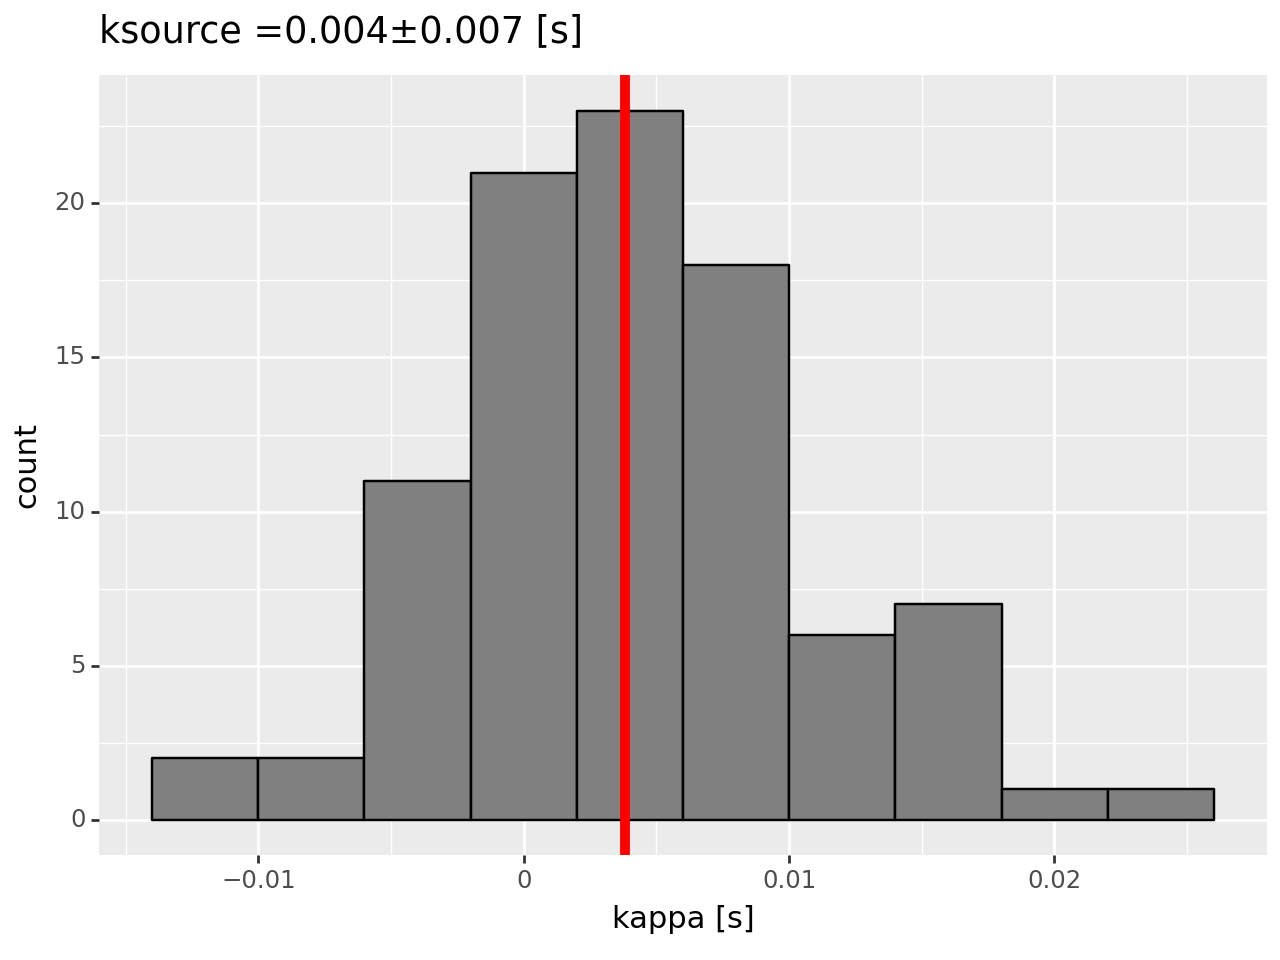

In [13]:
if ConfigFile.sourcetype != 1:   
    if opts.verb:print('.......START k source distribution plot')
    if opts.verb:print('.......please, close the graph to go on!')
    if opts.verb:print('')
    
    try:
        plot_ksource_distrib(dfresult,dfresult['kappa [s]'].mean(),dfresult['kappa [s]'].std(),ConfigFile.plot_graph,ConfigFile.save_graph,ConfigFile.out_dir,ConfigFile.type)
    except:
        print('------------')
        print('WARNING: failed plot for ksource distribution')
        print('------------')

#### Save Outputs

In [14]:
filename1 = "source_parameters"
json_filename = filename1 + '.json'
csv_filename =  filename1 + '.csv'
try:
    if opts.output == 'json' or opts.output == 'all':
        with open (ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + json_filename, 'w') as fp:
            json.dump(message, fp, sort_keys=False, cls=NumpyEncoder)
    if opts.output == 'csv' or opts.output == 'all':df_param.to_csv(ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + csv_filename,index = False)
    if len(result_dict['error_message']['ideve']) > 0:
        with open (ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + 'source_spectra_err', 'w') as fp:
            json.dump(result_dict['error_message'], fp, sort_keys=False, cls=NumpyEncoder)
    if opts.output == 'json' or opts.output == 'all':
        if len(result_dict['warnings']['ideve']) > 0:
            with open (ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + 'source_spectra_warning.json', 'w') as fp:
                json.dump(result_dict['warnings'], fp, sort_keys=False, cls=NumpyEncoder)    
    if opts.output == 'csv' or opts.output == 'all':
        df_warnings = pd.DataFrame(result_dict['warnings'])
        df_warnings.to_csv(ConfigFile.out_dir + '/fitmod' + str(ConfigFile.type) + '/' + 'source_spectra_warning.csv',index = False)
except Exception as e:
    print("No content in the table of results")
    sys.exit()